# Project: Wrangling and Analyze Data

## Dataset Overview (from Udacity Course)

### Enhanced Twitter Archive

The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356). I extracted this data programmatically, but I didn't do a very good job. The ratings probably aren't all correct. Same goes for the dog names and probably dog stages (see below for more information on these) too. You'll need to assess and clean these columns if you want to use them for analysis and visualization.

### Additional Data via the Twitter API

Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Well, "anyone" who has access to data for the 3000 most recent tweets, at least. But you, because you have the WeRateDogs Twitter archive and specifically the tweet IDs within it, can gather this data for all 5000+. And guess what? You're going to query Twitter's API to gather this valuable data.

### Image Predictions File

One more cool thing: I ran every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs*. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

## Installation of Packages / Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
# Download and upload the CSV file manually
# Read the CSV file into a Pandas DataFrame
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# Download the TSV file using the Requests library    
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [4]:
# Save the TSV file to directory
with open(os.path.join(url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

In [5]:
# Import the TSV file into a DataFrame
df_image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

In [6]:
# Check to see if the file was imported correctly
df_image_predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [7]:
# Read the provided JSON file line by line into a Pandas DataFrame
tweet_list = []
with open('tweet_json.txt', 'r', encoding='utf-8') as file:
    for line in file:
        tweets = json.loads(line)
        tweet_list.append(tweets)

df_tweet_json = pd.DataFrame(tweet_list, columns = ['id', 'retweet_count', 'favorite_count'])
df_tweet_json.head(1)

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Visual Assessment

In [8]:
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [9]:
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [10]:
df_tweet_json

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


### Programmatic Assessment

In [11]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [12]:
sum(df_twitter_archive['tweet_id'].duplicated())

0

In [13]:
pd.set_option("display.max_rows", None)
df_twitter_archive.name.value_counts()

None              745
a                  55
Charlie            12
Cooper             11
Lucy               11
Oliver             11
Tucker             10
Penny              10
Lola               10
Winston             9
Bo                  9
Sadie               8
the                 8
Daisy               7
Buddy               7
Toby                7
an                  7
Bailey              7
Leo                 6
Oscar               6
Stanley             6
Rusty               6
Bella               6
Dave                6
Jack                6
Koda                6
Scout               6
Jax                 6
Milo                6
Louis               5
Phil                5
Sammy               5
Gus                 5
Chester             5
Alfie               5
Sunny               5
Bentley             5
very                5
Oakley              5
Finn                5
George              5
Larry               5
Clarence            4
Loki                4
Walter              4
Reggie    

In [14]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [15]:
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [16]:
df_twitter_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [17]:
df_twitter_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [18]:
df_twitter_archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [19]:
df_twitter_archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [20]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [21]:
sum(df_image_predictions['tweet_id'].duplicated())

0

In [22]:
df_image_predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [23]:
df_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [24]:
df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [25]:
sum(df_tweet_json['id'].duplicated())

0

### Quality issues (observations)

This refers to **dirty data**, also known as low quality data. Low quality data has **content issues**. The four main data quality dimensions are:

- **Completeness**,  focused on whether we have all of the records we should (e.g. missing values)
- **Validity**,  focused on whether the data conforms to a defined schema (e.g. impossible values)
- **Accuracy**, focused on whether the data is incorrect (e.g. measurements)
- **Consistency**, focused on whether the data conforms to a standardized format (e.g. same units)

1. `retweeted_status_id` column in `df_twitter_archive` table: 181 tweets are retweets, not original tweets

2. `expanded_urls` column in `df_twitter_archive` table: 59 tweets have missing data

3. `name` column in `df_twitter_archive` table: 745 tweets have missing data ("None"), 104 tweets show implausible data (such as "a", "the", etc.)

4. `timestamp` column in `df_twitter_archive` table: Format is not datetime

5. `rating_numerator` and `rating_denominator` column in `df_twitter_archive` table: Additional column needed to provide a normalized dog rating (percentage), allowing for comparative analysis across the dataset

6. `img_num` column in `df_image_predictions` table: 295 tweets have more than 1 image which might result in ambiguous prediction or analysis results

7. `p1` column in `df_image_predictions` table: Predicted dog breeds are not consistently lower or uppercase

8. `tweet_id` respectively `id` column in all tables: Datatype is int while it should be object

### Tidiness issues (observations)

This refers to **messy data**, also known as untidy data. Untidy data has **structural issues**. There are three requirements for tidiness:

- Each variable forms a **column**
- Each observation forms a **row**
- Each type of observational unit forms a **table**


9. The `dogger` `floofer` `pupper` and `puppo` columns of the `df_twitter_archive` table all refer to the same variable and should be arranged in a single column `dog_stage` to meet the 1st tidiness requirement.

10. The `jpg_url` `p1` and `p1_conf` columns of the `df_image_predictions` table should be included in the `df_twitter_archive` table to meet the 3rd tidiness requirement.

11. The `retweet_count` and `favorite_count` column of the `df_tweet_json` table should be included in the `df_twitter_archive` table to meet the 3rd tidiness requirement. To enable joining, the `id` column of the `df_tweet_json` table should be renamed as `tweet_id`.

12. After joining the `df_image_predictions` and the `df_tweet_json` table with the `df_twitter_archive` table, only variables (columns) of interest should be kept (and renamed if that improves readability). All variables (columns) that won't be used for analysis can be dropped.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [26]:
# Make copies of original pieces of data
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_prediction_clean = df_image_predictions.copy()
df_tweet_json_clean = df_tweet_json.copy()

### Best Practice
The issues from above will be cleaned in best practice order (but keep their initial numbering from the assessment summary for better tracability): Address **Missing Data** before **Structural Issues (tidiness)** before **Content Issues (quality)**.

### Issue #1:

**Define**: Drop retweets from `df_twitter_archive` table (by only keeping rows where `retweeted_status_id` is null).

In [27]:
# Code
df_twitter_archive_clean = df_twitter_archive_clean[pd.isnull(df_twitter_archive_clean['retweeted_status_id'])]

In [28]:
# Test
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

### Issue #2:

**Define**: Drop tweets which have no data for `expanded_urls` from `df_twitter_archive` table.

In [29]:
# Code
df_twitter_archive_clean = df_twitter_archive_clean.dropna(subset = ['expanded_urls'])

In [30]:
# Test
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2117 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2117 non-null   object 
 4   source                      2117 non-null   object 
 5   text                        2117 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2117 non-null   int64  
 11  rating_denominator          2117 non-null   int64  
 12  name                        2117 non-null   object 
 13  doggo                       2117 

### Issue #3:

**Define**: Replace "None" by "Not specified" and only keep tweets which do not contain implausible strings (such as "a", "the", "an", "one", "very", "quite", "getting", "not", "by", "this", "mad", "all", "infuriating", "his", "my" - which are all lowercase) for `name` in `df_twitter_archive` table.

In [31]:
# Code
df_twitter_archive_clean['name'] = df_twitter_archive_clean['name'].str.replace('None', 'not specified')
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['name'].str[0].str.isupper()]

In [32]:
# Test
pd.set_option("display.max_rows", None)
df_twitter_archive_clean.name.value_counts()

Charlie           11
Lucy              11
Cooper            10
Oliver            10
Penny              9
Tucker             9
Sadie              8
Lola               8
Winston            8
Toby               7
Daisy              7
Bo                 6
Oscar              6
Stanley            6
Jax                6
Bella              6
Bailey             6
Koda               6
Rusty              5
Buddy              5
Dave               5
Scout              5
Milo               5
Bentley            5
Chester            5
Leo                5
Louis              5
Jeffrey            4
Jack               4
Scooter            4
Winnie             4
Bear               4
Jerry              4
Archie             4
Maggie             4
Oakley             4
Chip               4
Boomer             4
Sophie             4
Larry              4
Brody              4
George             4
Duke               4
Gus                4
Reggie             4
Derek              4
Phil               4
Cassie       

In [33]:
# Test
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1391 entries, 0 to 2325
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1391 non-null   int64  
 1   in_reply_to_status_id       1 non-null      float64
 2   in_reply_to_user_id         1 non-null      float64
 3   timestamp                   1391 non-null   object 
 4   source                      1391 non-null   object 
 5   text                        1391 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1391 non-null   object 
 10  rating_numerator            1391 non-null   int64  
 11  rating_denominator          1391 non-null   int64  
 12  name                        1391 non-null   object 
 13  doggo                       1391 

### Issue #4:

**Define**: Convert datatype of `timestamp` in `df_twitter_archive` table from string (object) to datetime and chop off the overhanging timezone digits.

In [34]:
# Code
df_twitter_archive_clean['timestamp'] = df_twitter_archive_clean['timestamp'].str.slice(stop=18)
df_twitter_archive_clean['timestamp'] = pd.to_datetime(df_twitter_archive_clean['timestamp'])

In [35]:
# Test
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1391 entries, 0 to 2325
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    1391 non-null   int64         
 1   in_reply_to_status_id       1 non-null      float64       
 2   in_reply_to_user_id         1 non-null      float64       
 3   timestamp                   1391 non-null   datetime64[ns]
 4   source                      1391 non-null   object        
 5   text                        1391 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               1391 non-null   object        
 10  rating_numerator            1391 non-null   int64         
 11  rating_denominator          1391 non-null   int64       

In [36]:
# Test
df_twitter_archive_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:05,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


### Issue #5:

**Define**: Create new column with a normalized dog rating (percentage) using `rating_numerator` and `rating_denominator` in `df_twitter_archive` table. Drop the old columns afterwards.

In [37]:
# Code
df_twitter_archive_clean['rating_percent'] = (df_twitter_archive_clean['rating_numerator']/df_twitter_archive_clean['rating_denominator'])*100
df_twitter_archive_clean.drop(['rating_numerator', 'rating_denominator'], axis=1, inplace=True)

In [38]:
# Test
df_twitter_archive_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,doggo,floofer,pupper,puppo,rating_percent
0,892420643555336193,NaN,NaN,2017-08-01 16:23:05,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,Phineas,None,None,None,None,130.0


### Issue #6:

**Define**: Drop tweets which have higher values than 1 for `img_num` in `df_image_prediction` table.

In [39]:
# Code
df_image_prediction_clean.drop(df_image_prediction_clean.loc[df_image_prediction_clean['img_num']>1].index, inplace=True)

In [40]:
# Test
df_image_prediction_clean.img_num.value_counts()

1    1780
Name: img_num, dtype: int64

### Issue #7:

**Define**: Change format of `p1` in `df_image_prediction` table to consistent lowercase.

In [41]:
# Code
df_image_prediction_clean.p1 = df_image_prediction_clean.p1.str.lower()

In [42]:
# Test
df_image_prediction_clean.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


### Issue #8:

**Define**: Convert datatype of `tweet_id` in all tables from int to string (object). Also, rename `id` in `df_tweet_json` table as `tweet_id`.

In [43]:
# Code
df_twitter_archive_clean.tweet_id = df_twitter_archive_clean.tweet_id.astype(object)
df_image_prediction_clean.tweet_id = df_image_prediction_clean.tweet_id.astype(object)
df_tweet_json_clean.id = df_tweet_json_clean.id.astype(object)
df_tweet_json_clean.rename(columns={'id':'tweet_id'}, inplace=True)

In [44]:
# Test
df_twitter_archive_clean.info()
df_image_prediction_clean.info()
df_tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1391 entries, 0 to 2325
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    1391 non-null   object        
 1   in_reply_to_status_id       1 non-null      float64       
 2   in_reply_to_user_id         1 non-null      float64       
 3   timestamp                   1391 non-null   datetime64[ns]
 4   source                      1391 non-null   object        
 5   text                        1391 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               1391 non-null   object        
 10  name                        1391 non-null   object        
 11  doggo                       1391 non-null   object      

### Issue #9:

**Define**: Create new column `dog_stage` by pulling the needed information from `text` (case sensitive!) and cross check with `doggo` `floofer` `pupper` and `puppo` in `df_twitter_archive` table. Drop old columns and turn NaN values into "Not specified".

In [45]:
# Code

df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean['text'].str.extract('(Doggo|doggo|Floofer|floofer|Pupper|pupper|Puppo|puppo)')
df_twitter_archive_clean.dog_stage = df_twitter_archive_clean.dog_stage.str.lower()

In [46]:
# Test
df_twitter_archive_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,doggo,floofer,pupper,puppo,rating_percent,dog_stage
2015,672205392827572224,NaN,NaN,2015-12-03 00:07:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Opal. He's a Royal John Coctostan. Rea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672205392...,Opal,None,None,pupper,None,90.0,pupper
879,760641137271070720,NaN,NaN,2016-08-03 00:59:01,"<a href=""http://twitter.com/download/iphone"" r...",This is Theo. He can walk on water. Still comi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/760641137...,Theo,None,None,None,None,120.0,NaN
1485,693155686491000832,NaN,NaN,2016-01-29 19:36:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Dunkin. He can only see when he's wet ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/693155686...,Dunkin,None,None,None,None,120.0,NaN
1544,689517482558820352,NaN,NaN,2016-01-19 18:39:01,"<a href=""http://twitter.com/download/iphone"" r...",This is Carl. He just wants to make sure you'r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/689517482...,Carl,None,None,None,None,120.0,NaN
652,792394556390137856,NaN,NaN,2016-10-29 15:55:05,"<a href=""http://twitter.com/download/iphone"" r...",Meet BeBe. She rocks the messy bun of your dre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792394556...,BeBe,None,None,None,None,120.0,NaN
705,785639753186217984,NaN,NaN,2016-10-11 00:34:04,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,Pinot,doggo,None,pupper,None,100.0,doggo
492,813217897535406080,NaN,NaN,2016-12-26 03:00:03,"<a href=""http://twitter.com/download/iphone"" r...",Here is Atlas. He went all out this year. 13/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813217897...,Atlas,None,None,None,None,130.0,NaN
1475,693642232151285760,NaN,NaN,2016-01-31 03:49:03,"<a href=""http://twitter.com/download/iphone"" r...",Meet Freddery. He's a Westminster Toblerone. S...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/693642232...,Freddery,None,None,None,None,90.0,NaN
1643,683857920510050305,NaN,NaN,2016-01-04 03:50:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sadie. She fell asleep on the beach and h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683857920...,Sadie,None,None,None,None,100.0,pupper
489,813910438903693312,NaN,NaN,2016-12-28 00:52:02,"<a href=""http://twitter.com/download/iphone"" r...",This is Chubbs. He dug a hole and now he's stu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813910438...,Chubbs,doggo,None,None,None,110.0,doggo


In [47]:
# Test
df_twitter_archive_clean.dog_stage.value_counts()

pupper     129
doggo       43
puppo       21
floofer      5
Name: dog_stage, dtype: int64

In [48]:
# Code
df_twitter_archive_clean.drop(['doggo', 'floofer','pupper', 'puppo'], axis=1, inplace=True)
df_twitter_archive_clean.dog_stage = df_twitter_archive_clean.dog_stage.fillna('not specified')

In [49]:
# Test
df_twitter_archive_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,rating_percent,dog_stage
1166,722613351520608256,NaN,NaN,2016-04-20 02:30:02,"<a href=""http://twitter.com/download/iphone"" r...",Meet Schnitzel. He's a Tropicana Floofboop. Ge...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722613351...,Schnitzel,120.0,not specified
38,884925521741709313,NaN,NaN,2017-07-12 00:01:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Earl. He found a hat. Nervous about wh...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884925521...,Earl,120.0,not specified
854,765222098633691136,NaN,NaN,2016-08-15 16:22:02,"<a href=""http://twitter.com/download/iphone"" r...",This is Gromit. He's pupset because there's no...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/765222098...,Gromit,100.0,not specified
765,777885040357281792,NaN,NaN,2016-09-19 15:00:02,"<a href=""http://twitter.com/download/iphone"" r...",This is Wesley. He's clearly trespassing. Seem...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/777885040...,Wesley,30.0,not specified
668,790277117346975746,NaN,NaN,2016-10-23 19:42:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bruce. He never backs down from a chal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/790277117...,Bruce,110.0,not specified
772,776477788987613185,NaN,NaN,2016-09-15 17:48:02,"<a href=""http://twitter.com/download/iphone"" r...",This is Huck. He's addicted to caffeine. Hope ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776477788...,Huck,110.0,pupper
1312,707014260413456384,NaN,NaN,2016-03-08 01:25:01,"<a href=""http://twitter.com/download/iphone"" r...",This is Ellie. She requests to be carried arou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707014260...,Ellie,110.0,not specified
1967,673342308415348736,NaN,NaN,2015-12-06 03:24:05,"<a href=""http://twitter.com/download/iphone"" r...",This is Django. He's a skilled assassin pupper...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673342308...,Django,100.0,pupper
2163,669375718304980992,NaN,NaN,2015-11-25 04:43:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Billl. He's trying to be a ghost but h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669375718...,Billl,60.0,not specified
1320,706346369204748288,NaN,NaN,2016-03-06 05:11:01,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. She's a Beneboom Cumberwiggle. 1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706346369...,Koda,120.0,not specified


### Issue #10:

**Define**: Join `jpg_url` `p1` and `p1_conf` from `df_image_prediction` table into `df_twitter_archive` table.

In [50]:
# Code
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_image_prediction_clean[['tweet_id','jpg_url', 'p1', 'p1_conf']], on='tweet_id', how='inner')

In [51]:
# Test
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,rating_percent,dog_stage,jpg_url,p1,p1_conf
0,892420643555336193,NaN,NaN,2017-08-01 16:23:05,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,Phineas,130.0,not specified,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049
1,892177421306343426,NaN,NaN,2017-08-01 00:17:02,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,Tilly,130.0,not specified,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,chihuahua,0.323581
2,891815181378084864,NaN,NaN,2017-07-31 00:18:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,Archie,120.0,not specified,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,chihuahua,0.716012
3,891689557279858688,NaN,NaN,2017-07-30 15:58:05,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,Darla,130.0,not specified,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,0.170278
4,890971913173991426,NaN,NaN,2017-07-28 16:27:01,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",Jax,130.0,not specified,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,appenzeller,0.341703


In [52]:
# Test
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1151
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    1152 non-null   object        
 1   in_reply_to_status_id       1 non-null      float64       
 2   in_reply_to_user_id         1 non-null      float64       
 3   timestamp                   1152 non-null   datetime64[ns]
 4   source                      1152 non-null   object        
 5   text                        1152 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               1152 non-null   object        
 10  name                        1152 non-null   object        
 11  rating_percent              1152 non-null   float64     

### Issue #11:

**Define**: Join `retweet_count` and `favorite_count` from `df_tweet_json` table into `df_twitter_archive` table.

In [53]:
# Code
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_tweet_json_clean[['tweet_id','retweet_count', 'favorite_count']], on='tweet_id', how='inner')

In [54]:
# Test
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1151
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    1152 non-null   object        
 1   in_reply_to_status_id       1 non-null      float64       
 2   in_reply_to_user_id         1 non-null      float64       
 3   timestamp                   1152 non-null   datetime64[ns]
 4   source                      1152 non-null   object        
 5   text                        1152 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               1152 non-null   object        
 10  name                        1152 non-null   object        
 11  rating_percent              1152 non-null   float64     

In [55]:
# Test
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,rating_percent,dog_stage,jpg_url,p1,p1_conf,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:05,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,Phineas,130.0,not specified,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,8853,39467
1,892177421306343426,NaN,NaN,2017-08-01 00:17:02,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,Tilly,130.0,not specified,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,chihuahua,0.323581,6514,33819
2,891815181378084864,NaN,NaN,2017-07-31 00:18:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,Archie,120.0,not specified,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,chihuahua,0.716012,4328,25461
3,891689557279858688,NaN,NaN,2017-07-30 15:58:05,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,Darla,130.0,not specified,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,0.170278,8964,42908
4,890971913173991426,NaN,NaN,2017-07-28 16:27:01,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",Jax,130.0,not specified,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,appenzeller,0.341703,2158,12041


### Issue #12:

**Define**: From the resulting dataset `df_twitter_archive_master`, drop all columns that won't be used for analysis. Rename relevant columns if it improves readability.

In [56]:
# Code
df_twitter_archive_master = df_twitter_archive_clean
df_twitter_archive_master.drop(['source', 'in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)
df_twitter_archive_master.rename(columns={'expanded_urls' : 'tweet_url', 'name': 'dog_name', 'p1': 'dog_breed_prediction', 'p1_conf' : 'prediction_confidence'}, inplace=True)

In [57]:
# Test
df_twitter_archive_master.head()

,tweet_id,timestamp,text,tweet_url,dog_name,rating_percent,dog_stage,jpg_url,dog_breed_prediction,prediction_confidence,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:05,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,130.0,not specified,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,8853,39467
1,892177421306343426,2017-08-01 00:17:02,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,130.0,not specified,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,chihuahua,0.323581,6514,33819
2,891815181378084864,2017-07-31 00:18:00,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,120.0,not specified,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,chihuahua,0.716012,4328,25461
3,891689557279858688,2017-07-30 15:58:05,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,130.0,not specified,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,0.170278,8964,42908
4,890971913173991426,2017-07-28 16:27:01,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",Jax,130.0,not specified,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,appenzeller,0.341703,2158,12041


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [58]:
df_twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [59]:
from IPython.display import Image
pd.set_option("max_colwidth", 100)

In [60]:
# Loading Dataset
df_master = pd.read_csv('twitter_archive_master.csv')

In [61]:
# Preview Dataset
df_master.head(1)

,tweet_id,timestamp,text,tweet_url,dog_name,rating_percent,dog_stage,jpg_url,dog_breed_prediction,prediction_confidence,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:05,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas,130.0,not specified,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,8853,39467


#### Basic Statistics and Display of Images
We use the `describe` method with the `df_master` table to gain insight into its basic statistics and go on from there.

In [62]:
# Show Statistics
df_master.describe()

,tweet_id,rating_percent,prediction_confidence,retweet_count,favorite_count
count,1.152000e+03,1152.000000,1152.000000,1152.000000,1152.000000
mean,7.390666e+17,121.741748,0.576701,2535.524306,8695.693576
std,6.865556e+16,520.910740,0.276061,3902.046381,11217.580781
min,6.664188e+17,20.000000,0.044333,23.000000,107.000000
25%,6.769273e+17,100.000000,0.342224,619.000000,2090.250000
50%,7.120789e+17,110.000000,0.548416,1370.000000,4166.000000
75%,7.932299e+17,120.000000,0.835877,3063.000000,11339.750000
max,8.924206e+17,17760.000000,1.000000,56625.000000,107956.000000


In [63]:
# Finding Tweet with highest retweet_count
df_master[df_master.retweet_count == df_master.retweet_count.max()].head()

,tweet_id,timestamp,text,tweet_url,dog_name,rating_percent,dog_stage,jpg_url,dog_breed_prediction,prediction_confidence,retweet_count,favorite_count
249,807106840509214720,2016-12-09 06:17:02,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,https://twitter.com/dog_rates/status/807106840509214720/video/1,Stephan,130.0,not specified,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,chihuahua,0.50537,56625,107015


In [64]:
# Show image for tweet with highest retweet_count
Image(url = 'https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg')

In [65]:
# Finding Tweet with highest favorite_count
df_master[df_master.favorite_count == df_master.favorite_count.max()].head()

,tweet_id,timestamp,text,tweet_url,dog_name,rating_percent,dog_stage,jpg_url,dog_breed_prediction,prediction_confidence,retweet_count,favorite_count
41,879415818425184262,2017-06-26 19:07:02,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/...,https://twitter.com/dog_rates/status/879415818425184262/video/1,Duddles,130.0,not specified,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,english_springer,0.383404,45849,107956


In [66]:
# Show image for tweet with highest favorite_count
Image(url = 'https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg')

### Insights:
1. `rating_percent`: The normalized rating result has a mean of 121.74 percent, indicating the unique rating system is representing a very positive mindset among users (= dog lovers).

2. `prediction_confidence`: For the dog breed prediction confidence from the neural network, a mean of 0.58 and a standard deviation of 0.28 are indicating it has a solid yet volatile accuracy.

3. `retweet_count` and `favourite_count`: The top ranking tweets for each variable are from December 2016 / June 2017 and are showing a Chihuahua / English Springer. Both are presenting a video rather than a still image.

### Visualization

In [67]:
from matplotlib.dates import date2num
from datetime import datetime

#### TOP 10 dog names
We use the `dog_name` column in the `df_master` table to visualize the most common dog names.

Text(0, 0.5, 'Name')

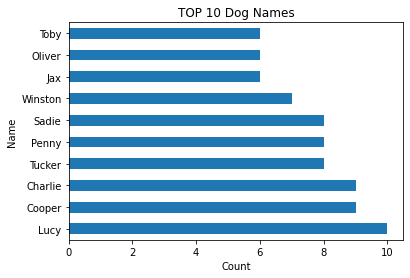

In [68]:
# Histogram for TOP 10 dog names
dog_name = df_master.groupby('dog_name').filter(lambda x: len(x) >= 2)
dog_name['dog_name'].value_counts()[:10].plot(kind = 'barh')
plt.title('TOP 10 Dog Names')
plt.xlabel('Count')
plt.ylabel('Name')

In [69]:
# Verify Histogram
df_master.dog_name.value_counts()

Lucy              10
Charlie            9
Cooper             9
Sadie              8
Penny              8
Tucker             8
Winston            7
Toby               6
Oliver             6
Lola               6
Jax                6
Bo                 5
Scout              5
Rusty              5
Daisy              5
Bella              5
Gary               4
Reggie             4
Milo               4
Scooter            4
Stanley            4
Gus                4
Leo                4
Alfie              4
Chip               4
Larry              4
Oscar              4
Jack               4
Clarence           4
Chester            4
Derek              4
Dave               4
Buddy              4
Koda               4
Cassie             4
Sophie             4
Jerry              4
Ruby               3
Brody              3
Bear               3
Walter             3
George             3
Maggie             3
Finn               3
Wallace            3
Phil               3
Moose              3
Rosie        

#### TOP 10 dog breeds
We use the `dog_breed_prediction` column in the `df_master` table to visualize the most common dog breeds.

Text(0, 0.5, 'Breed')

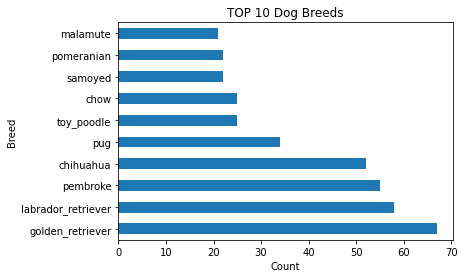

In [70]:
# Histogram for TOP 10 dog breeds
dog_breed = df_master.groupby('dog_breed_prediction').filter(lambda x: len(x) >= 2)
dog_breed['dog_breed_prediction'].value_counts()[:10].plot(kind='barh')
plt.title('TOP 10 Dog Breeds')
plt.xlabel('Count')
plt.ylabel('Breed')

In [71]:
# Verify Histogram
df_master.dog_breed_prediction.value_counts()

golden_retriever                  67
labrador_retriever                58
pembroke                          55
chihuahua                         52
pug                               34
toy_poodle                        25
chow                              25
pomeranian                        22
samoyed                           22
malamute                          21
french_bulldog                    19
siberian_husky                    17
staffordshire_bullterrier         14
cocker_spaniel                    14
miniature_pinscher                12
german_shepherd                   12
seat_belt                         12
chesapeake_bay_retriever          11
beagle                            11
shih-tzu                          11
pekinese                          11
cardigan                          10
shetland_sheepdog                 10
old_english_sheepdog              10
vizsla                            10
italian_greyhound                 10
eskimo_dog                        10
l

#### Number of tweets over time
We use the `timestamp` column in the `df_master` table to visualize the number of (weekly) tweets over time.

In [72]:
# convert timestamp to datetime again
df_master['timestamp'] = pd.to_datetime(df_master['timestamp'])

In [73]:
# check datatype of timestamp being datetime
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1152 non-null   int64         
 1   timestamp              1152 non-null   datetime64[ns]
 2   text                   1152 non-null   object        
 3   tweet_url              1152 non-null   object        
 4   dog_name               1152 non-null   object        
 5   rating_percent         1152 non-null   float64       
 6   dog_stage              1152 non-null   object        
 7   jpg_url                1152 non-null   object        
 8   dog_breed_prediction   1152 non-null   object        
 9   prediction_confidence  1152 non-null   float64       
 10  retweet_count          1152 non-null   int64         
 11  favorite_count         1152 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory u

Text(0, 0.5, 'Tweet count')

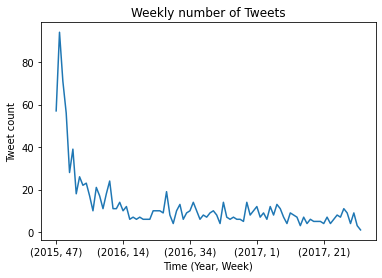

In [74]:
# Line Chart for number of weekly tweets
timeline = df_master['tweet_id'].groupby([df_master['timestamp'].dt.year, df_master['timestamp'].dt.isocalendar().week]).count()
timeline.plot(kind='line')
plt.title('Weekly number of Tweets')
plt.xlabel('Time (Year, Week)')
plt.ylabel('Tweet count')

Resources: www.classroom.udacity.com www.stackoverflow.com www.numpy.org www.pandas.pydata.org www.matplotlib.org